# Установка нужных библиотек

Рекомендую использовать виртуальное окружение venv и python==3.10

In [30]:
! pip install pandas numpy catboost seaborn matplotlib scikit-learn lightgbm xgboost imblearn pytorch-tabnet -q

# Импорт библиотек

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 50)

# Импорт данных

In [6]:
train, test = pd.read_csv('./data/train_AIC.csv'), pd.read_csv('./data/test_AIC.csv')
train.head()

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,Вариант поставки,НРП,Длительность,До поставки,Месяц1,Месяц2,Месяц3,День недели 2,Сумма,Количество позиций,Количество,Количество обработчиков 7,Количество обработчиков 15,Количество обработчиков 30,Согласование заказа 1,Согласование заказа 2,Согласование заказа 3,Изменение даты поставки 7,Изменение даты поставки 15,Изменение даты поставки 30,Отмена полного деблокирования заказа на закупку,Изменение позиции заказа на закупку: изменение даты поставки на бумаге,Изменение позиции заказа на закупку: дата поставки,Количество циклов согласования,Количество изменений после согласований,Дней между 0_1,Дней между 1_2,Дней между 2_3,Дней между 3_4,Дней между 4_5,Дней между 5_6,Дней между 6_7,Дней между 7_8,y
0,606,7448,4,5,1,1,9,1,1,150,1,0.0,190,190,10,4,1,3,6.740725,1,4.0,4,4,4,1,1,1,1.0,1.0,1.0,0,1,1,1.0,11,82.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
1,7,27439,1,1,21,15,255,12,3,12,2,1.0,17,12,9,9,9,0,7.876672,22,20.0,6,7,7,0,0,0,0.0,0.0,0.0,0,0,0,0.0,11,12.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0
2,318,27213,1,20,11,12,4,1,1,11,2,1.0,67,43,5,7,6,0,5.029520,1,1.0,5,5,6,1,1,1,0.0,0.0,0.0,0,0,0,1.0,12,27.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
3,1768,19949,5,2,1,1,55,1,1,34,1,0.0,83,66,12,2,12,4,5.987879,5,6.0,7,7,7,1,1,1,1.0,1.0,1.0,0,1,1,1.0,14,2.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,0
4,7,27439,1,1,12,9,8,1,3,12,2,0.0,21,18,12,12,12,1,7.839027,85,20.0,2,2,2,0,0,0,0.0,0.0,0.0,0,0,0,0.0,7,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


# Работа с данными

![Alt text](image.png)

### Очистка данных

In [7]:
# удаляю дупбликаты
print(train.duplicated().sum())
train = train.drop_duplicates()

4658


In [8]:
# проверяю на NaN
train.isna().sum().sum()

0

In [1]:
class student:
    def __init__(self, surname, name, cls, bdate):
        self.surname = surname
        self.name = name
        self.cls = cls
        self.bdate = bdate

In [2]:
def get_inp():
    surname = input()
    name = input()
    cls = input()
    bdate = input()
    return [surname, name, cls, bdate]

In [4]:
n = int(input())

students = []

for i in range(n):
    s = student(*get_inp())
    students.append(s)

students = sorted(students, key=lambda x: x.cls + x.surname)

for s in students:
    print(s.cls, s.surname, s.name, s.bdate)

   
   
 Sidorov Sidor 9A 20.07.93  


In [9]:
# в описании данных написано, что этот признак не рекомендуется 
train = train.drop(columns=['Количество позиций'], errors='ignore')
test = test.drop(columns=['Количество позиций'], errors='ignore')

In [10]:
# переименовываю все признаки для удобства
rename_list = ['provider', 'material', 'category_manager', 'operation_manager', 'factory', 'purchase_org', 'purchase_group',
               'balance_unit', 'unit', 'material_group', 'supply_variant', 'NRP', 'duration', 'before_supply', 'mon1', 'mon2', 'mon3',
               'weekday2', 'sum', 'quantity', 'n_handlers_7', 'n_handlers_15', 'n_handlers_30', 'agreement_1', 'agreement_2', 'agreement_3',
               'change_date_7', 'change_date_15', 'change_date_30', 'cancel_deblock', 'change_paper', 'change', 'n_loops_agreement', 'n_changes',
               '0_1', '1_2', '2_3', '3_4', '4_5', '5_6', '6_7', '7_8']

rename_dict = {test.columns[i]: rename_list[i] for i in range(len(test.columns))}

train = train.rename(columns=rename_dict)
test = test.rename(columns=rename_dict)

train.head(2)

,provider,material,category_manager,operation_manager,factory,purchase_org,purchase_group,balance_unit,unit,material_group,supply_variant,NRP,duration,before_supply,mon1,mon2,mon3,weekday2,sum,quantity,n_handlers_7,n_handlers_15,n_handlers_30,agreement_1,agreement_2,agreement_3,change_date_7,change_date_15,change_date_30,cancel_deblock,change_paper,change,n_loops_agreement,n_changes,0_1,1_2,2_3,3_4,4_5,5_6,6_7,7_8,y
0,606,7448,4,5,1,1,9,1,1,150,1,0.0,190,190,10,4,1,3,6.740725,4.0,4,4,4,1,1,1,1.0,1.0,1.0,0,1,1,1.0,11,82.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1
1,7,27439,1,1,21,15,255,12,3,12,2,1.0,17,12,9,9,9,0,7.876672,20.0,6,7,7,0,0,0,0.0,0.0,0.0,0,0,0,0.0,11,12.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0


In [11]:
# категориальные признаки
cat_features = ['provider', 'material', 'category_manager', 'operation_manager', 'factory', 'purchase_org', 
                'purchase_group', 'balance_unit', 'unit', 'material_group', 'supply_variant', 'mon1', 'mon2', 'mon3', 'weekday2']

### Анализ

Я предполагаю, что ответ сильно зависит от таких признаков как Сумма заказа на поставку (sum) и Длительность (duration), стоит добавить такие признаки, как сумма договоренностей (sum_agreements) и остальные суммы исчесляемых признаков, а так же разницы между месяцами.

In [12]:
fi_clf = CatBoostClassifier(20)
fi_clf.fit(train.drop(columns='y'), train['y'], verbose=0)
fi_clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,duration,36.098410
1,before_supply,31.896254
2,n_handlers_15,4.037243
3,n_handlers_30,3.556524
4,n_changes,2.849369
5,operation_manager,2.514987
6,provider,2.153527
7,n_loops_agreement,2.018093
8,agreement_1,1.679545
9,purchase_group,1.675807


In [13]:
# добавляю признаки
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['sum_handlers'] = df['n_handlers_7'] + df['n_handlers_15'] + df['n_handlers_30'] + df['n_handlers_30']
    df['sum_days_0_8'] = df['0_1'] + df['1_2'] + df['2_3'] + df['3_4'] + df['4_5'] + df['5_6'] + df['6_7'] + df['7_8']
    df['sum_change_date'] = df['change_date_15'] + df['change_date_30'] + df['change_date_7']
    df['mon3-mon2'] = df['mon3'] - df['mon2']
    df['mon3-mon1'] = df['mon3'] - df['mon1']
    df['mon2-mon1'] = df['mon2'] - df['mon1']
    df['sum_agreements'] = df['agreement_1'] + df['agreement_2'] + df['agreement_3']
    return df

train = add_features(train)
test = add_features(test)

train.head(1)

,provider,material,category_manager,operation_manager,factory,purchase_org,purchase_group,balance_unit,unit,material_group,supply_variant,NRP,duration,before_supply,mon1,mon2,mon3,weekday2,sum,quantity,n_handlers_7,n_handlers_15,n_handlers_30,agreement_1,agreement_2,agreement_3,change_date_7,change_date_15,change_date_30,cancel_deblock,change_paper,change,n_loops_agreement,n_changes,0_1,1_2,2_3,3_4,4_5,5_6,6_7,7_8,y,sum_handlers,sum_days_0_8,sum_change_date,mon3-mon2,mon3-mon1,mon2-mon1,sum_agreements
0,606,7448,4,5,1,1,9,1,1,150,1,0.0,190,190,10,4,1,3,6.740725,4.0,4,4,4,1,1,1,1.0,1.0,1.0,0,1,1,1.0,11,82.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1,16,79.0,3.0,-3,-9,-6,3


Посмотрю на Feaure Importance

In [14]:
fi_clf = CatBoostClassifier(20)
fi_clf.fit(train.drop(columns='y'), train['y'], verbose=0)
fi_clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,before_supply,34.759282
1,duration,33.263578
2,n_changes,2.491717
3,provider,2.402298
4,n_handlers_7,2.386856
5,n_handlers_30,2.371297
6,sum_days_0_8,2.288702
7,operation_manager,2.159019
8,n_loops_agreement,1.759067
9,balance_unit,1.580369


Некоторые добавленные признаки, составленные из слабых признаков и вправду стали иметь больший вес, а так же гипотеза о том, что duration - сильный признак, подтвердилась

<Figure size 640x480 with 0 Axes>

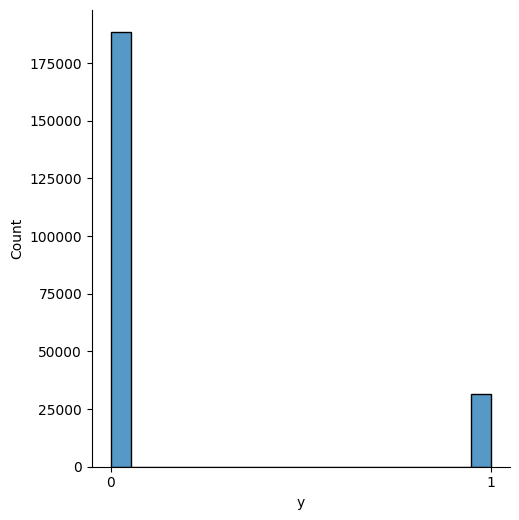

In [15]:
# проверяю распределение целевого признака
plt.figure()
g = sns.displot(train['y'])
plt.xticks([0, 1])
plt.tight_layout(pad=.0)
plt.show()

Данные сильно несбалансированны, по этому далее применяю технику undersampling

### Андерсемплинг

In [16]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
train_undersampled = undersampler.fit_resample(train.drop(columns='y'), train['y'])

train_undersampled[1].value_counts()

y
0    31719
1    31719
Name: count, dtype: int64

## Подготовка данных для обучения

In [17]:
# разбиение данных на обучающую и валидационную выборки

x_train, x_test, y_train, y_test = train_test_split(train_undersampled[0], train_undersampled[1])
#x_train, x_test, y_train, y_test = train_test_split(train.drop(columns='y'), train['y'])

x_train.shape, x_test.shape

((47578, 49), (15860, 49))

# Моделирование

Я решил сделать ансамбль градиентных бустингов и нейронной сети, использовав технику стекинга. Модели первого слоя (catboost, lgbm, xgboost, tabnet) обучаются на уравновешенном наборе данных из ~60000 примеров, а второго слоя (мета-модель - catboost) - на полном наборе данных из ~220000 примеров

Известно, что стекинг может сильно увеличить точность решения в сложной задаче

## Слой 1

### CatBoost

In [18]:
cb_clf = CatBoostClassifier(
    iterations=10000,
    l2_leaf_reg=7, # тк в датасете много признаков, использую большое пенальти
    use_best_model=True, # использую лучшие веса
    eval_metric='F1', # метрика
    task_type='GPU', # ускоряю обучение на видеокарте
    early_stopping_rounds=80, # защита от переобучения
    depth=9, # большая глубина для нелинейных признаков
    leaf_estimation_method='Newton',
    bootstrap_type='Bernoulli',
    grow_policy='Depthwise'
)

cb_clf.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=100, cat_features=cat_features)

0:	learn: 0.7468965	test: 0.7508310	best: 0.7508310 (0)	total: 116ms	remaining: 19m 24s
100:	learn: 0.8907839	test: 0.8547135	best: 0.8547135 (100)	total: 11.8s	remaining: 19m 20s
200:	learn: 0.9283749	test: 0.8754653	best: 0.8754653 (200)	total: 21.6s	remaining: 17m 34s
300:	learn: 0.9417067	test: 0.8800927	best: 0.8800927 (300)	total: 29.9s	remaining: 16m 2s
400:	learn: 0.9515674	test: 0.8854617	best: 0.8856255 (396)	total: 37.9s	remaining: 15m 8s
500:	learn: 0.9597491	test: 0.8876569	best: 0.8876569 (500)	total: 46.8s	remaining: 14m 46s
600:	learn: 0.9654177	test: 0.8896476	best: 0.8898372 (594)	total: 54.9s	remaining: 14m 17s
700:	learn: 0.9699242	test: 0.8914237	best: 0.8915457 (699)	total: 1m 2s	remaining: 13m 51s
800:	learn: 0.9733979	test: 0.8917221	best: 0.8923190 (736)	total: 1m 10s	remaining: 13m 32s
bestTest = 0.8923189555
bestIteration = 736
Shrink model to first 737 iterations.


In [19]:
# оценка точности классификатора
f1_score(np.array(y_test), cb_clf.predict(x_test))

0.8923189555243731

### LightGBM

In [20]:
categorical_features_index = [i for i in range(train.shape[1]) if train.columns[i] in cat_features]

params_lgbm = {
    "num_leaves": 500,
    "n_estimators": 100,
    "min_child_samples": 5,
    "min_data_in_leaf": 10, # помогает обучаться на нелинейных признаках
    "feature_fraction": 0.7, # защита от переобучения
    'reg_alpha' : 3.0, # пенальти
    'reg_lambda' : 5.0, # пенальти
    'categorical_feature': categorical_features_index,
}

In [21]:
lgbm_clf = LGBMClassifier(**params_lgbm)

In [22]:
lgbm_clf.fit(x_train, y_train)

c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\lightgbm\basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Number of positive: 23643, number of negative: 23935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8226
[LightGBM] [

LGBMClassifier(categorical_feature=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15,
                                    16, 17],
               feature_fraction=0.7, min_child_samples=5, min_data_in_leaf=10,
               num_leaves=500, reg_alpha=3.0, reg_lambda=5.0)

In [23]:
# оценка точности модели
f1_score(y_test, lgbm_clf.predict(x_test))

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


0.8860512005865461

### XGBoost

In [24]:
params_xgb = {
    'n_estimators' : 2500,
    "subsample": 0.7, # защита от переобучения
    'min_child_weight' : 0.1,
    'gamma': .01, # пенальти
    'reg_lambda' : 0.1, # пенальти
    'reg_alpha' : 0.5, # пенальти
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    'device': 'cuda',
    'tree_method' : 'hist',
    'enable_categorical' : True
}

xgb_clf = XGBClassifier(**params_xgb)

In [25]:
xgb_clf.fit(x_train, y_train)

c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mae', feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=0.1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=2500, n_jobs=None,
              num_parallel_tree=None, objective='reg:squarederror', ...)

In [26]:
# оценка точности модели
f1_score(y_test, xgb_clf.predict(x_test))

c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated 

0.8836558354630644

### Tabnet

Известно, что приминение моделей с разной архитектурой увеличивает обобщающую способность ансамбля, поэтому приминение нейронной сети среди бустингов может улучшить скор

In [32]:
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier()

clf.fit(
  x_train.values, y_train,
  eval_set=[(x_test.values, y_test)],
)

c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.68429 | val_0_auc: 0.55293 |  0:00:06s
epoch 1  | loss: 0.64659 | val_0_auc: 0.60631 |  0:00:13s
epoch 2  | loss: 0.63756 | val_0_auc: 0.66811 |  0:00:19s
epoch 3  | loss: 0.62865 | val_0_auc: 0.69124 |  0:00:25s
epoch 4  | loss: 0.6245  | val_0_auc: 0.70168 |  0:00:31s
epoch 5  | loss: 0.62048 | val_0_auc: 0.71274 |  0:00:37s
epoch 6  | loss: 0.61236 | val_0_auc: 0.72023 |  0:00:43s
epoch 7  | loss: 0.60868 | val_0_auc: 0.73331 |  0:00:49s
epoch 8  | loss: 0.59691 | val_0_auc: 0.7443  |  0:00:56s
epoch 9  | loss: 0.58772 | val_0_auc: 0.76731 |  0:01:02s
epoch 10 | loss: 0.55112 | val_0_auc: 0.81522 |  0:01:08s
epoch 11 | loss: 0.49432 | val_0_auc: 0.85082 |  0:01:14s
epoch 12 | loss: 0.45541 | val_0_auc: 0.87317 |  0:01:20s
epoch 13 | loss: 0.45525 | val_0_auc: 0.86571 |  0:01:26s
epoch 14 | loss: 0.43305 | val_0_auc: 0.89131 |  0:01:32s
epoch 15 | loss: 0.41134 | val_0_auc: 0.89166 |  0:01:38s
epoch 16 | loss: 0.41276 | val_0_auc: 0.84299 |  0:01:44s
epoch 17 | los

c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [34]:
# оценка точности модели
f1_score(y_test, clf.predict(x_test.values))

0.7466254218222722

## Метамодель

In [35]:
# собираю данные для обучения мета-модели
meta_train = train.copy()
meta_train['cb_clf'] = cb_clf.predict(train.drop(columns='y'))
meta_train['lgbm_clf'] = lgbm_clf.predict(train.drop(columns='y'))
meta_train['xgb_clf'] = xgb_clf.predict(train.drop(columns='y'))
meta_train['tabnet_probas_0'] = list(map(lambda x : x[0], clf.predict_proba(train.drop(columns='y').values)))
meta_train['tabnet_probas_1'] = list(map(lambda x : x[1], clf.predict_proba(train.drop(columns='y').values)))

x_train_meta, x_test_meta, y_train_meta, y_test_meta = train_test_split(meta_train.drop(columns='y'), meta_train.y)

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated 

In [36]:
meta_train.head(1)

,provider,material,category_manager,operation_manager,factory,purchase_org,purchase_group,balance_unit,unit,material_group,supply_variant,NRP,duration,before_supply,mon1,mon2,mon3,weekday2,sum,quantity,n_handlers_7,n_handlers_15,n_handlers_30,agreement_1,agreement_2,...,change_paper,change,n_loops_agreement,n_changes,0_1,1_2,2_3,3_4,4_5,5_6,6_7,7_8,y,sum_handlers,sum_days_0_8,sum_change_date,mon3-mon2,mon3-mon1,mon2-mon1,sum_agreements,cb_clf,lgbm_clf,xgb_clf,tabnet_probas_0,tabnet_probas_1
0,606,7448,4,5,1,1,9,1,1,150,1,0.0,190,190,10,4,1,3,6.740725,4.0,4,4,4,1,1,...,1,1,1.0,11,82.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1,16,79.0,3.0,-3,-9,-6,3,1,1,1,0.180201,0.819799


In [39]:
meta_clf = CatBoostClassifier(
    iterations=3000,
    task_type='GPU',
    use_best_model=True,
    cat_features=cat_features,
    early_stopping_rounds=75,
    loss_function='Logloss',
    eval_metric='F1',
    l2_leaf_reg=9,
    leaf_estimation_method='Newton',
    bootstrap_type='Bayesian',
)

meta_clf.fit(x_train_meta, y_train_meta, eval_set=(x_test_meta, y_test_meta), verbose=100)

0:	learn: 0.8174621	test: 0.8179074	best: 0.8179074 (0)	total: 235ms	remaining: 11m 45s
100:	learn: 0.8329573	test: 0.8395134	best: 0.8395134 (100)	total: 34.3s	remaining: 16m 25s
200:	learn: 0.8388191	test: 0.8491006	best: 0.8497162 (195)	total: 1m 6s	remaining: 15m 28s
300:	learn: 0.8417813	test: 0.8525637	best: 0.8531729 (255)	total: 1m 38s	remaining: 14m 42s
bestTest = 0.8531729323
bestIteration = 255
Shrink model to first 256 iterations.


In [40]:
# Финальный локальный скор
f1_score(y_test_meta, meta_clf.predict(x_test_meta))

0.853172932330827

# Сабмишн

In [41]:
meta_test = test.copy()
meta_test['cb_clf'] = cb_clf.predict(test)
meta_test['lgbm_clf'] = lgbm_clf.predict(test)
meta_test['xgb_clf'] = xgb_clf.predict(test)
meta_test['tabnet_probas_0'] = list(map(lambda x : x[0], clf.predict_proba(test.values)))
meta_test['tabnet_probas_1'] = list(map(lambda x : x[1], clf.predict_proba(test.values)))

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated 

In [43]:
cb_clf.save_model('./saved_models/cb_clf')
lgbm_clf.booster_.save_model('./saved_models/lgbm_clf')
xgb_clf.save_model('./saved_models/xgb_clf')
clf.save_model('./saved_models/tabnet_clf')
meta_clf.save_model('./saved_models/meta_clf')

c:\Users\Windows_11\Desktop\соревы\aiijc_production_finals\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [23:31:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Successfully saved model at ./saved_models/tabnet_clf.zip


In [42]:
meta_preds = meta_clf.predict(meta_test)

final_preds = meta_preds.copy()

sub_df = pd.DataFrame({
    'id': test.index,
    'value': final_preds
})

sub_df.to_csv('submissions/submission.csv', index=False)

In [44]:
df = pd.read_csv('./data/test_AIC.csv')
df.head(1)

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,Вариант поставки,НРП,Длительность,До поставки,Месяц1,Месяц2,Месяц3,День недели 2,Сумма,Количество позиций,Количество,Количество обработчиков 7,Количество обработчиков 15,Количество обработчиков 30,Согласование заказа 1,Согласование заказа 2,Согласование заказа 3,Изменение даты поставки 7,Изменение даты поставки 15,Изменение даты поставки 30,Отмена полного деблокирования заказа на закупку,Изменение позиции заказа на закупку: изменение даты поставки на бумаге,Изменение позиции заказа на закупку: дата поставки,Количество циклов согласования,Количество изменений после согласований,Дней между 0_1,Дней между 1_2,Дней между 2_3,Дней между 3_4,Дней между 4_5,Дней между 5_6,Дней между 6_7,Дней между 7_8
0,273,269,6,8,1,1,64,1,9,22,1,1.0,45,36,9,11,9,6,6.560264,2,10.0,8,8,8,2,2,1,0.0,0.0,0.0,0,0,0,1.0,16,0.0,0.0,1.0,0.0,0.0,-1.0,-1.0,-1.0


In [45]:
df.head(3).to_csv('./test.csv', index=False)